# Singular Value Decomposition

The Singular Value Decomposition (SVD) is a topic that is not part of the standard linear algebra introduction, but is possibly the most incredibly powerful tool in the field. The SVD makes many mathematical proofs very straightforward, and has immediate applications in

* compression,
* error analysis,
* convex **and** non-convex optimization,

...just to name a few.

### Python Setup

In [1]:
# Render MPL figures within notebook cells
%matplotlib inline

# Import python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Configure some defaults for plots
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (10, 3)

In [3]:
# Set Numpy's random number generator so the same results are produced each time the notebook is run
np.random.seed(0)

### Derivation

The SVD is a way of decomposing a matrix into smaller matrices with very well-defined structure. We can do a nice derivation of the derivation, again, geometrically:

We start with the fun fact that if you transform a sphere of unit radius by **any** matrix $A$, the resulting points make an ellipse. Notice that we are **not restricted in any way** on the matrix $A$ here.

<img src='img/svd.png' style='height: 200px'>

The output ellipse is defined by a set of mutually orthogonal principal axis vectors, $u$. Orthogonality, as a reminder, means that the inner product between two different vectors in the set is zero:  
<br>
<center>
    $u_1^{\mathsf{T}}u_2 = 0$
</center>
<br>

An absolutely remarkable result is that - working backwards - the input vectors $v$ that map onto the principle axes **also** form a mutually orthogonal set. For simplicity, we'll scale the $u$ and $v$ vectors to have unit length, and use coefficients $\sigma$ to make the equality work out.

<br>
<center>
    $Av=\sigma u$
</center>
<br>

Now, we can horizontally stack all the vectors into matrices:  

<br>
<center>
    $AV=U\Sigma$
</center>
<br>

The matrix $\Sigma$ contains the scaling coefficients $\sigma$ along its main diagonal:

<img src='img/svd_matrices.png' style='height: 200px'>

We need one last piece, which comes from exploiting the fact that these new matrices $U$ and $V$ are built from mutually orthogonal vectors with length 1. These are called **orthogonal** matrices, and have the property that  

<br>
<center>
    $V^\mathsf{T} V = VV^\mathsf{T} = I \\
    U^\mathsf{T} U = UU^\mathsf{T} = I$
</center>
<br>

Therefore, we can conclude that **any** matrix $A$ can be written in the form  

<br>
<center>
    $A=U\Sigma V^\mathsf{T}$
</center>
<br>

This is the singular value decomposition, where "singular values" refers to the scaling coefficients $\sigma$. Let's dive into how we can use this thing for fun and profit.


### Pseudoinverse

We saw in the previous section the least squares and least norm solutions when solving problems of the form $y = Ax$. The SVD provides an inconceivably simple way of arriving at these solutions *simultaneously*. 

1. Drop any rows or columns in $\Sigma$ that have only zeros such that it becomes a square, diagonal matrix. If A has rank $r$, this will give $U \in \mathbb{R}^{m, r}$, $V \in \mathbb{R}^{n, r}$, and $\Sigma \in \mathbb{R}^{r, r}$.
2. Now, by construction the matrix $V\Sigma^{-1}U^{\mathsf{T}}$ is an inverse to $U\Sigma V^{\mathsf{T}}$ (this is super easy to test)
3. Therefore, $x = V\Sigma^{-1}U^{\mathsf{T}}y$

It's easy to show just by substituting the SVD into the least squares and least norm solutions that one arrives at the same result. Try this at home - cancelling everything out is immensely satisfying.

The matrix $V\Sigma^{-1}U^{\mathsf{T}}$ is so significant that it has a fancy name, the **Moore-Penrose Pseudoinverse**. It also has a fancy notation, $A^{\dagger}$.

### Basis for the Nullspace

I mentioned in the dicussion on the nullspace back in chapter 1 that there would be a way to get the basis vectors for the nullspace. If $A$ has rank $r$, then the last $n-r$ columns of $V$ are those basis vectors! These are the directions in the input space that get multiplied by singular values of zero, and are, thus, flattened.

### Error Analysis

Suppose you have a linear system with some small error, $\delta$ in the observed measurement such that $y = Ax + \delta$. If you solve using the pseudoinverse, the resulting error in the estimate of $x$ will be $V\Sigma^{-1} U^{\mathsf{T}}\delta$. A property of $U$ and $V$ as orthogonal matrices is that, when viewed as a transform, they only rotate or reflect - lengths of vectors are preserved. This means the only thing that affects the magnitude of the error is $\Sigma^{-1}$. This is a diagonal matrix whose entries are $\sigma_i^{-1}$ - if $\sigma_i$ is very, very small, then this means you have very, very big numbers multiplying your errors!

You will see people refer to matrices as **well-conditioned** or **ill-conditioned**. These terms indicate whether the matrix has these very small singular values and is at risk of producing large errors. How small is small, though? Since size is relative, the standard is to normalize to the largest singular value. This gives us the concept of the **condition number**:  

<br>
<center>
    $k = \frac{\sigma_{max}}{\sigma_{min}}$
</center>
<br>

When $k$ is large, there is a wide spread in the singular values and our estimates may be very sensitive to small changes or noise.

### Low-Rank Approximation

For any matrix that you would obtain from *measurements* of something, as opposed to analytically, it's basically guaranteed that the matrix will be full rank. Suppose you build a measurement system whose corresponding matrix is **not** full rank - if you so much as speak loudly nearby, the infinitesimal noise you introduce will add some floating point-level error that a computer will correctly identify as "full rank". Practically, though, your matrix is still singular.

The SVD provides a handy solution - simply round the smallest singular values to zero. One can show this is actually an optimal approximation to the original matrix $A$ under a particular cost function (the details are beyond the scope of what I'm covering here, but the Boyd lectures explain it well!). How small should you set the threshold? That depends on your application. We'll see an example below.

#### Compression

I mentioned in the discussion on rank that any matrix $A$ can be factored into component matrices such that $A = QR$, which require storing fewer elements than the original matrix depending on the rank of $A$. The SVD provides us with an immediate way of getting $Q$ and $R$. If $A$ is low rank - implying that transforming by $A$ flattens some dimensions - then some of the singular values will be zero. We can drop the rows and columns of $U$ and $V$ corresponding to those singular values and merge $\Sigma$ into either of them:

<br>
<center>
    $A=U\Sigma V^\mathsf{T}=U(\Sigma V^\mathsf{T})=QR$
</center>
<br>

More interestingly, the SVD provides a mechanism for *lossy* compression as well, based on the low-rank approximation idea presented above.  We round the singular values below some threshold to zero:

In [4]:
# Construct a matrix with a relatively low rank

m = 1000
n = 500
r = 10

Q = np.random.rand(m, r)
R = np.random.rand(r, n)
A = Q @ R

In [5]:
# Perform the Singular Value Decomposition
U, Σ, Vt = np.linalg.svd(A)

print('U:', U.shape)
print('S:', Σ.shape)
print('Vt:', Vt.shape)

U: (1000, 1000)
S: (500,)
Vt: (500, 500)


In the figure below, notice how the singular values beyond $\text{rank(A)}$ (sorted from largest to smallest) are not precisely zero - this is due to floating point rounding error.

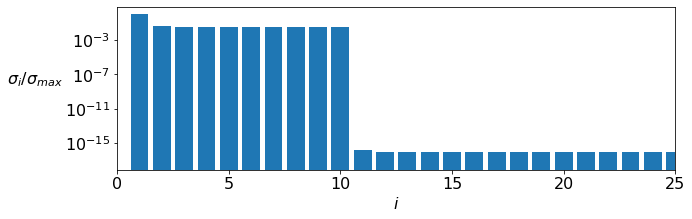

In [6]:
plt.bar(np.arange(Σ.size) + 1, Σ/Σ.max())
plt.xlim(0, 25)
plt.yscale('log')
plt.ylabel('$\sigma_i / \sigma_{max}$', rotation=0, labelpad=30)
plt.xlabel('$i$')
plt.show()

In [8]:
# Numpy will still identify A as full rank, depending on a tolerance argument
np.linalg.matrix_rank(A, tol=1e-33)

500

In [9]:
np.linalg.matrix_rank(A, tol=1e-5)

10

In [10]:
# Demonstrate compression savings
# We want A = QR

r = 10
Q = U[:, :r]
R = np.diag(Σ[:r]) @ Vt[:r, :]

In [13]:
# Number of elements to store A
A.size

500000

In [14]:
# Number of elements to store factorized matrices
Q.size + R.size

15000

#### Document Search

Below is another fun example of how low-rank approximation can be applied. We have a set of $n$ documents, and within each document we count the number of instances of $m$ specific words. Ultimately, our goal is to be able to sort the documents by relevance given a target word. The problem is set up so that there are patterns in word usage. In fact, there are 3 general categories of document - music, math, and cats. The word usage definitely clusters by genre, but there are some spurious cases that break the pattern. SVD will help us identify the patterns despite the noise by finding the best approximation.

We start by setting up the problem data:

In [16]:
words = np.array([
    'drums',
    'piano',
    'chords',
    'bayesian',
    'matrix',
    'coefficient',
    'fluffy',
    'meow'
])

titles = np.array([
    'Music Theory for Beginners',
    'A History of Jazz',
    'Beethoven vs. Mechagodzilla',
    'Elements of Statistical Learning',
    'Finite Element Methods: the Hottest Trends',
    'Introduction to Linear Algebra',
    '10 Fluffy Cats you need to see RIGHT NOW!!!',
    'The Lost Art of Grooming',
    'Piano Cat Strikes Again'
])

word_counts = [
    [ 5, 5,  2, 0, 0, 0,  0,  0],
    [10, 3,  6, 0, 0, 0,  0,  0],
    [ 0, 8, 12, 0, 0, 0,  0,  0],
    [ 0, 0,  0, 5, 6, 4,  0,  0],
    [ 0, 0,  0, 9, 4, 4,  0,  0],
    [ 0, 0,  0, 2, 5, 6,  0,  0],
    [ 0, 0,  0, 0, 0, 0, 10, 10],
    [ 0, 0,  0, 0, 0, 0,  4,  5],
    [ 0, 2,  0, 0, 0, 0,  5, 11]
]

A = np.array(word_counts).T
m, n = A.shape

A

array([[ 5, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  3,  8,  0,  0,  0,  0,  0,  2],
       [ 2,  6, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  9,  2,  0,  0,  0],
       [ 0,  0,  0,  6,  4,  5,  0,  0,  0],
       [ 0,  0,  0,  4,  4,  6,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  4,  5],
       [ 0,  0,  0,  0,  0,  0, 10,  5, 11]])

Next, we'll look at our singular values:

In [19]:
# Normalize the columns to remove the effect of word counts from each document
A_norm = A / A.sum(axis=0)

# Perform the Singular Value Decomposition
U, Σ, Vt = np.linalg.svd(A_norm)

print('U:', U.shape)
print('S:', Σ.shape)
print('Vt:', Vt.shape)

U: (8, 8)
S: (8,)
Vt: (9, 9)


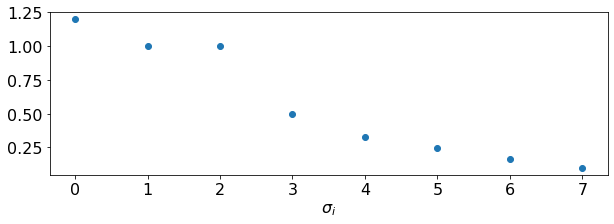

In [20]:
plt.plot(Σ, marker='o', lw=0)
plt.xlabel('$\sigma_i$')
plt.show()

Notice how the first 3 singular values are more significant than the later ones. Using the language of Principal Component Analysis, we would say the first three vectors in $U$ and $V$ "explain most of the variance" of the word count data. In more pure linear algebra speak, we would say $A$ is approximately rank 3.

It's enlightening to look at the first 3 vectors in $U$ and $V$:

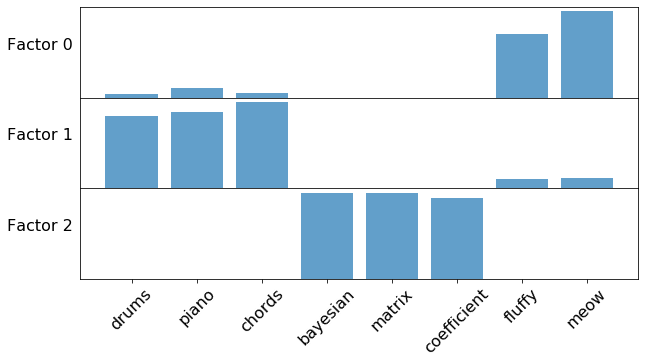

In [21]:
# Plot the principal basis vectors for the search terms

fig, axs = plt.subplots(3, sharex=True, figsize=(10, 5))
plt.subplots_adjust(hspace=0)

for i in range(3):
    plt.sca(axs[i])
    plt.bar(range(m), abs(U[:, i]), alpha=0.7)
    plt.yticks([])
    plt.ylabel('Factor {}'.format(i), rotation='horizontal', labelpad=40)
    
plt.xticks(range(m), words, rotation=45)
plt.show()

The vectors in $U$ contain information about the clustering of the keywords.

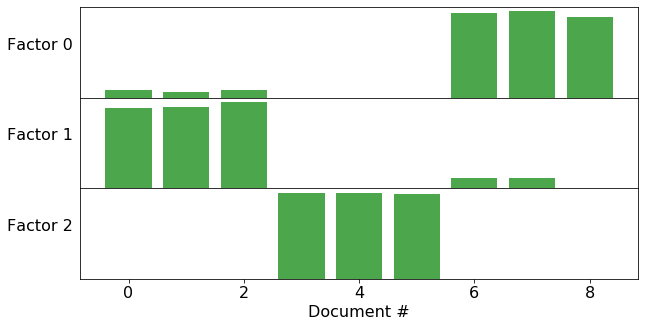

In [22]:
# Plot the principal basis vectors for the documents

fig, axs = plt.subplots(3, sharex=True, figsize=(10, 5))
plt.subplots_adjust(hspace=0)

for i in range(3):
    plt.sca(axs[i])
    plt.bar(range(n), abs(Vt.T[:, i]), color='g', alpha=0.7)
    plt.yticks([])
    plt.ylabel('Factor {}'.format(i), rotation='horizontal', labelpad=40)
    
plt.xlabel('Document #')
plt.show()

The vectors in $V$ contain information about the clustering of the documents.

If we were to reconstruct $A$ using only these first 3 vectors from $U$ and $V$ (equivalent to setting the remining singular values to zero), this is similar to saying the information in the remaining vectors is just noise. In our example, that translates roughly as "while we have 8 distinct words, there are really only 3 *things* that matter." Similarly, "while there are 9 distinct documents, there are only 3 *things* that matter."

In [23]:
# Construct a rank 3 approximation of A

A_hat = U[:, :3] @ np.diag(Σ[:3]) @ Vt[:3, :]
A_hat /= np.linalg.norm(A_hat, axis=0)
np.round(A_hat, 2)

array([[ 0.53,  0.53,  0.53,  0.  ,  0.  ,  0.  , -0.02, -0.02,  0.03],
       [ 0.57,  0.57,  0.57,  0.  ,  0.  ,  0.  ,  0.04,  0.04,  0.09],
       [ 0.63,  0.63,  0.63, -0.  , -0.  , -0.  , -0.02, -0.02,  0.04],
       [ 0.  , -0.  , -0.  ,  0.59,  0.59,  0.59,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.  , -0.  ,  0.59,  0.59,  0.59, -0.  , -0.  ,  0.  ],
       [ 0.  , -0.  , -0.  ,  0.56,  0.56,  0.56,  0.  , -0.  ,  0.  ],
       [-0.  , -0.02, -0.  , -0.  , -0.  , -0.  ,  0.59,  0.59,  0.59],
       [ 0.01, -0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.8 ,  0.8 ,  0.8 ]])

If we want to order the documents by relevance, we can now probe the "overlap" of a query vector with each document. If we did this with the original matrix $A$, then we would just retrieve the documents sorted by the prevalence of the target word. With our approximation, however, we have re-scored each document in terms of the 3 **latent factors** rather than words, and our search will now rank by the prevalence of those factors. 

The mathematical way of describing the similarity between two vectors is an inner product, so to create the ranking we take the inner product of our search vector with each column of $\hat$

In [426]:
# Perform a search
search_term = 1
print('Searching for {}...\n'.format(words[search_term]))

# The search vector, x, is a vector of zeros with a '1' for the desired term. If we were to search for
# multiple words, we would normalize x to have unit norm
x = np.zeros(m)
x[search_term] = 1

# Compute the scores by projecting x onto each "document" (the columns of A_hat)
scores = abs(A_hat.T @ x)

# Sort the titles based on their scores, in descending order
rank = np.argsort(scores)[::-1]
sorted_titles = titles[rank]

# Print the results
for i in range(5):
    print(sorted_titles[i])
print('...')

Searching for piano...

Music Theory for Beginners
Beethoven vs. Mechagodzilla
A History of Jazz
Piano Cat Strikes Again
The Lost Art of Grooming
...
